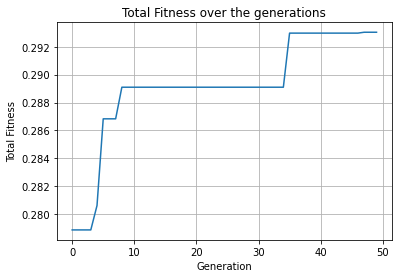

116450.00000000001


,Buchanan 1,Buchanan 2,Henry Angus 1,Henry Angus 2,Henry Angus 3,ESB 1,ESB 2,ESB 3,CHEM 1,CHEM 2
Hours,,,,,,,,,,
First hour,['MATH 105'],['ATSC 113'],['POLI 101'],['SOCI 102'],['EOSC 116'],['CPSC 110'],['LING 101'],['VISA 110'],['WRDS 150'],['SOCI 101']
Second hour,['CHEM 154'],['PHYS 131'],['PHYS 158'],['CHEM 123'],['FREN 101'],['DSCI 100'],['CPSC 103'],['POLI 110'],['PSYC 101'],['PSYC 102']
third hour,['CHEM 154'],['MATH 101'],['FREN 101'],['MATH 103'],['PHYS 170'],['BIOL 140'],['ENGL 110'],['GEOS 102'],['PHIL 120'],['EOSC 114']
fourth hour,['JAPN 100'],['MATH 102'],['CHEM 123'],['POLI 100'],['BIOL 140'],['ANTH 100'],['PHYS 159'],['DSCI 100'],['EOSC 114'],['LING 100']
Fifth Hour,['CPSC 110'],['ATSC 113'],['ANTH 100'],['MATH 104'],['GRSJ 101'],['PHYS 157'],['CPSC 103'],['ENGL 110'],['MATH 152'],['EOSC 116']


In [1]:
import copy
import operator
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt


class Genetic:
    """
    A Genetic Algorithm class
    """

    def __init__(self, buildings=None, residences=None) -> None:
        """
        The following are performed in this __init__ function
        - Initialize the genetic algorithm class
        - reads in timetable data
        - Encodes courses to integers ranging from [0,37]
        - Initialize a population
        """

        # Reading in data
        data = pd.read_csv("data/students.csv")[["mandatory_1", "mandatory_2",
                                                 "mandatory_3", "elective_1",
                                                 "elective_2"]]
        self.data = np.array(data).tolist()
        self.place_vanier, self.ochard, self.totem = self.data[:10], self.data[10:20], self.data[20:]

        info_ = []
        for i in data.columns:
            info_.extend(data[i].unique().tolist())
        self.info = dict(list(zip(range(40), list(sorted(set(info_))))))
#         print(self.info)
        self.encoding = {value: key for key, value in self.info.items()}
        self.chromosome = list(range(38)) + list(range(12))
        self.buildings = buildings
        self.residences = residences
        self.population = []
        self.distances = {"Place Vanier": {"Buch": 550, "HenryAngus": 400, "ESB": 700, "CHEM": 950},
                          "Ochard": {"Buch": 1100, "HenryAngus": 800, "ESB": 400, "CHEM": 500},
                          "Totem Park": {"Buch": 1500, "HenryAngus": 1100, "ESB": 800, "CHEM": 850},

                          "Buch": {"Buch": 0, "HenryAngus": 400, "ESB": 700, "CHEM": 900},
                          "HenryAngus": {"Buch": 400, "HenryAngus": 0, "ESB": 400, "CHEM": 700},
                          "ESB": {"Buch": 700, "HenryAngus": 400, "ESB": 0, "CHEM": 260},
                          "CHEM": {"Buch": 900, "HenryAngus": 700, "ESB": 260, "CHEM": 0}}
        self.pop_size = 100
        self.n_keep = 5
        self.n_reproduce = self.pop_size // self.n_keep

        np.random.seed(42)
        for i in range(self.pop_size):
            self.population.append(np.random.permutation(self.chromosome).tolist())

    def fitness(self, pop: list) -> int:
        """
        returns the total fitness of the gene pool
        :param pop: gene pool (population)
        :return: fitness value of the gene pool
        """
        schedule = {"Buch": [],
                    "HenryAngus": [],
                    "ESB": [],
                    "CHEM": []}
        for chrom in pop:
            first_hour = list(chrom[:10])
            sec_hour = list(chrom[10:20])
            third_hour = list(chrom[20:30])
            fourth_hour = list(chrom[30:40])
            fifth_hour = list(chrom[40:])
            schedule["Buch"].extend(first_hour[:2] + sec_hour[:2] + third_hour[:2] + fourth_hour[:2] + fifth_hour[:2])
            schedule["HenryAngus"].extend(first_hour[2:5] + sec_hour[2:5] + third_hour[2:5] + fourth_hour[2:5]+ fifth_hour[2:5])
            schedule["ESB"].extend(first_hour[5:8] + sec_hour[5:8] + third_hour[5:8] + fourth_hour[5:8]+ fifth_hour[5:8])
            schedule["CHEM"].extend(first_hour[8:] + sec_hour[8:] + third_hour[8:] + fourth_hour[8:] + fifth_hour[8:])

        cost = 0

        for student in self.place_vanier:
            for course in student:
                for building in ["Buch", "HenryAngus", "ESB", "CHEM"]:
                    cost += self.distances["Place Vanier"][building] if self.encoding[course] in schedule[
                        building] else 0

        for student in self.ochard:
            for course in student:
                for building in ["Buch", "HenryAngus", "ESB", "CHEM"]:
                    cost += self.distances["Ochard"][building] if self.encoding[course] in schedule[
                        building] else 0

        for student in self.totem:
            for course in student:
                for building in ["Buch", "HenryAngus", "ESB", "CHEM"]:
                    cost += self.distances["Totem Park"][building] if self.encoding[course] in schedule[
                        building] else 0

        fitness = 1 / np.sqrt(cost) * 100

        return fitness

    def loop(self, generations: int) -> list:
        """
        :@param: generations: The number of generations that the algorithm should run for.
        """
        fitnesses = []
        fitness_sums = []
        for i in range(generations):

            # Calculate Individual Fitness in population
            fitnesses = [(idx, self.fitness([individual])) for idx, individual in enumerate(self.population)]

            # Sort population from most fit to least fit
            most_fit = sorted(fitnesses, key=operator.itemgetter(1), reverse=True)

            # Append the most fit chromosome to *fitness_sums*
            fitness_sums.append(most_fit[0][1])
            chromosomes = []

            # Create a temporary list to keep mutated chromosomes
            new_pop = []

            # Keep the `n_keep` most fit chromosomes, create `n_reproduce`. mutations of the chromosomes.
            for idx, _ in most_fit[:self.n_keep]:
                parent = self.population[idx]
                children = [self.mutated_child(parent, rate=1) for _ in range(self.n_reproduce - 1)]
                children.append(parent)
                new_pop += children

            self.population = new_pop
        plt.grid()
        plt.plot(fitness_sums)
        plt.xlabel("Generation")
        plt.ylabel("Total Fitness")
        plt.title("Total Fitness over the generations")
        plt.show()
        plt.close()
#         print(f"Length of new population: {len(self.population)}")

        pop = [(individual, self.fitness([individual])) for individual in self.population]
        sorted_pop = sorted(pop, key=operator.itemgetter(1), reverse = True)
        best_fit, fitness_ = sorted_pop[0][0], sorted_pop[0][1]

        return best_fit, fitness_

    @staticmethod
    def crossover(chromosomes: list, rate: float) -> list:
        first_chromosome, second_chromosome = list(chromosomes)
        chrome_a = list(first_chromosome[:20]) + list(second_chromosome[20:])
        chrome_b = list(second_chromosome[:20]) + list(first_chromosome[20:])
        chromes = []
        random_num = random.random()
        if random_num < rate:
            chromes.append(chrome_a)
            chromes.append(chrome_b)
            return chromes
        else:
            return chromosomes



    @staticmethod
    def mutated_child(individual: list, rate: float) -> list:
        """
        Function slightly mutate chromosome with a strength based on the rate
        The mutation is a random shuffle.
        """
        child = copy.deepcopy(individual)
        if random.random() < rate:
            random.shuffle(child)
        return child

    def __repr__(self):
        return f'A representation of the genetic algorithm class'


if __name__ == "__main__":
    gen = Genetic()
    timetable_, fitness = gen.loop(generations=50)
    distance = (1 /(fitness / 100))**2
    print(distance)
    timetable = []
    for i in timetable_:
        timetable.append(gen.info[i])
    first_hour = timetable[:10]
    sec_hour = timetable[10:20]
    third_hour = timetable[20:30]
    fourth_hour = timetable[30:40]
    fifth_hour = timetable[40:]
    df = pd.DataFrame(data={"Buchanan 1": [first_hour[0], sec_hour[0], third_hour[0], fourth_hour[0], fifth_hour[0]],
                           "Buchanan 2": [first_hour[1], sec_hour[1], third_hour[1], fourth_hour[1], fifth_hour[1]],
                           "Henry Angus 1": [first_hour[2], sec_hour[2], third_hour[2], fourth_hour[2], fifth_hour[2]],
                           "Henry Angus 2": [first_hour[3], sec_hour[3], third_hour[3], fourth_hour[3], fifth_hour[3]],
                           "Henry Angus 3": [first_hour[4], sec_hour[4], third_hour[4], fourth_hour[4], fifth_hour[4]],
                           "ESB 1": [first_hour[5], sec_hour[5], third_hour[5], fourth_hour[5], fifth_hour[5]],
                           "ESB 2": [first_hour[6], sec_hour[6], third_hour[6], fourth_hour[6], fifth_hour[6]],
                           "ESB 3": [first_hour[7], sec_hour[7], third_hour[7], fourth_hour[7], fifth_hour[7]],
                           "CHEM 1": [first_hour[8], sec_hour[8], third_hour[8], fourth_hour[8], fifth_hour[8]],
                           "CHEM 2": [first_hour[9], sec_hour[9], third_hour[9], fourth_hour[9], fifth_hour[9]],
                           "Hours": ["First hour", "Second hour", "third hour", "fourth hour", "Fifth Hour"]}).set_index("Hours")
    df = df.style.set_caption("A Good Solution")
    display(df)